In [1]:
import warnings

import gymnasium as gym
import numpy as np
import pandas as pd
import requests
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.vec_env import DummyVecEnv, VecEnvWrapper
from stable_baselines3.common.evaluation import evaluate_policy

from gym_trading.envs.data_loader import PandasAssetChartDataLoader
from gym_trading.envs.exchange import BaseExchange
from gym_trading.envs.renderer import PlotRenderer
from gym_trading.envs.rewards import ProfitRewarder
from gym_trading.envs.action_space import BudgetAllocationSpace

from abc import ABC, abstractmethod

# Hide all warnings
warnings.filterwarnings("ignore")

In [2]:
def get_symbol_history(symbol, n_days):
    url = f'https://api.coingecko.com/api/v3/coins/{symbol}/market_chart'
    params = {
        'vs_currency': 'usd',
        'days': str(n_days),
    }
    response = requests.get(url, params=params)
    data = response.json()

    # Extract dates and prices from the API response
    timestamps = data['prices']
    dates = [pd.to_datetime(timestamp, unit='ms') for timestamp, _ in timestamps]
    prices = [price for _, price in timestamps]
    market_caps = [market_cap for _, market_cap in data['market_caps']]
    total_volumes = [total_volume for _, total_volume in data['total_volumes']]
    
    print(f'{symbol.upper()}: {len(dates) = }, {len(prices) = }, {len(market_caps) = }, {len(total_volumes) = }')

    return pd.DataFrame({
        'Date': dates,
        'Price': prices,
        'Market Cap': market_caps,
        'Total Volume': total_volumes
    })

BITCOIN: len(dates) = 1441, len(prices) = 1441, len(market_caps) = 1441, len(total_volumes) = 1441
ETHEREUM: len(dates) = 1441, len(prices) = 1441, len(market_caps) = 1441, len(total_volumes) = 1441
LITECOIN: len(dates) = 1441, len(prices) = 1441, len(market_caps) = 1441, len(total_volumes) = 1441
RIPPLE: len(dates) = 1441, len(prices) = 1441, len(market_caps) = 1441, len(total_volumes) = 1441


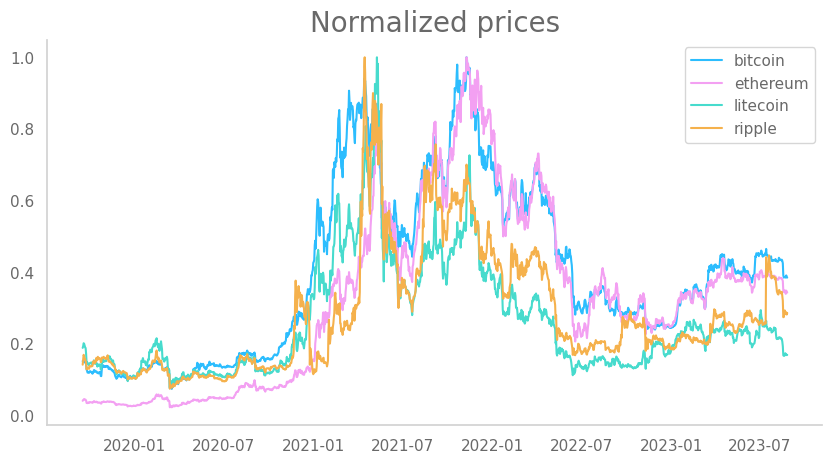

In [3]:
N_DAYS = 360 * 4

SYMBOLS = [
    'bitcoin', 
    'ethereum', 
    'litecoin',
    'ripple'
]
datasets = {}

df = pd.DataFrame()

for symbol in SYMBOLS:
    df = get_symbol_history(symbol, N_DAYS)

    # removing the last row since someimes are not aligned
    df.drop(df.index[-1], inplace=True)

    plt.plot(df['Date'], df['Price'] / np.max(df['Price']), label=symbol)
    datasets[symbol] = df

plt.title('Normalized prices')
plt.legend()
plt.show()

In [4]:
def train_valid_test_df(df, split_rate=0.2):
    train_df, test_df = train_test_split(df, test_size=split_rate, shuffle=False)
    train_df, valid_df = train_test_split(train_df, test_size=split_rate, shuffle=False)
    return train_df, valid_df, test_df

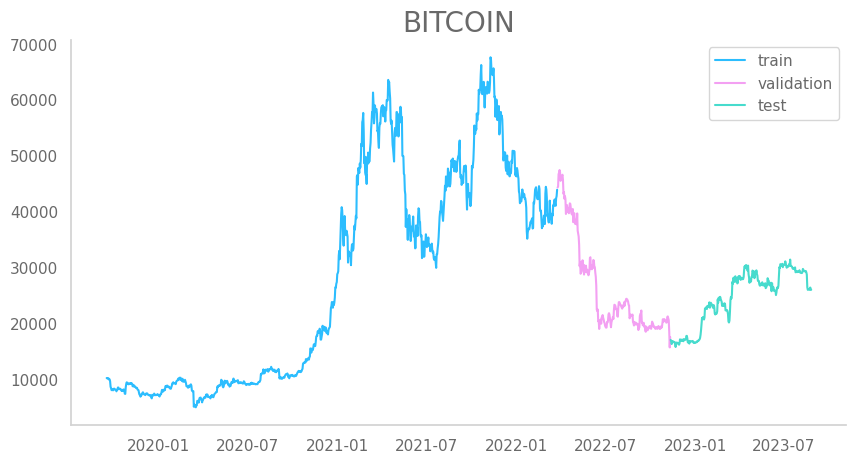

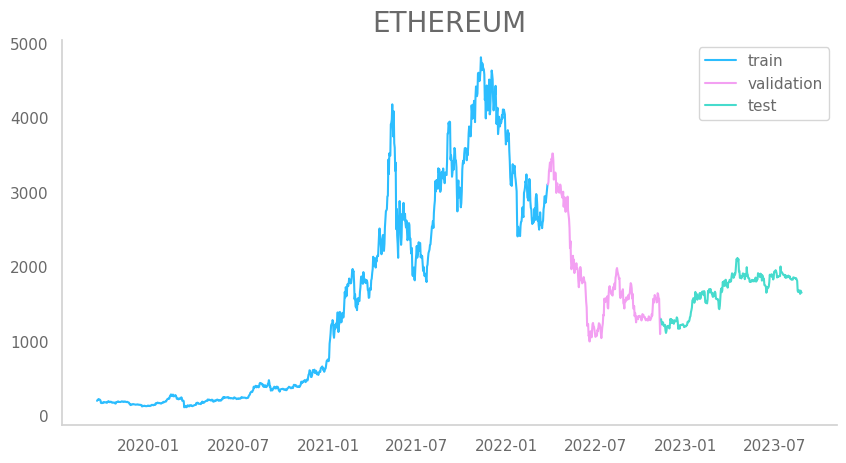

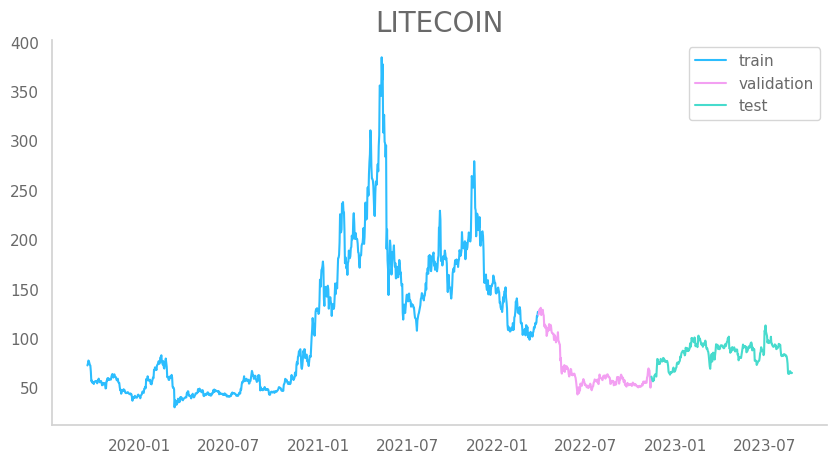

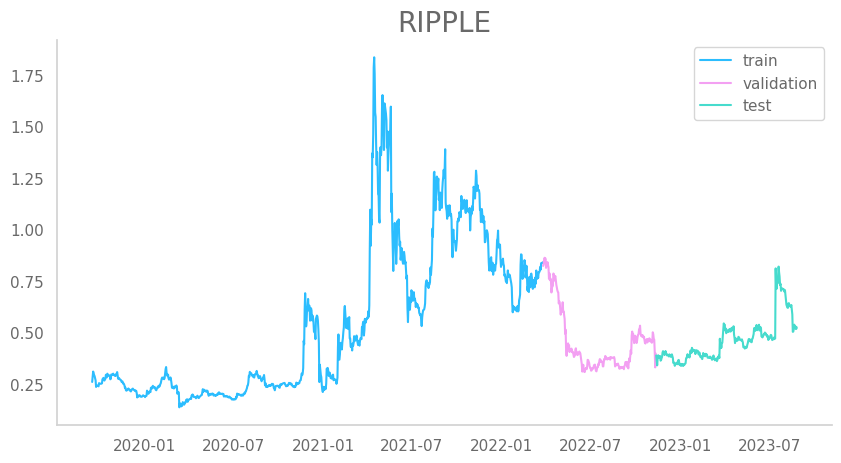

In [5]:
split_datasets = {}
for symbol, df in datasets.items():
    split_datasets[symbol] = train_valid_test_df(df)

    plt.plot(split_datasets[symbol][0]['Date'], split_datasets[symbol][0]['Price'], label=f'train')
    plt.plot(split_datasets[symbol][1]['Date'], split_datasets[symbol][1]['Price'], label=f'validation')
    plt.plot(split_datasets[symbol][2]['Date'], split_datasets[symbol][2]['Price'], label=f'test')

    plt.title(symbol.upper())
    plt.legend()
    plt.show()

In [6]:
# split_datasets[SYMBOLS[0]][0].describe()
# split_datasets[SYMBOLS[0]][1].describe()
# split_datasets[SYMBOLS[0]][2].describe()

In [7]:
INIT_LIQUIDITY = 100.0
BUY_FEE = 0.1
SELL_FEE = 0.1

# TRAIN ENV
train_data_loader = PandasAssetChartDataLoader(
    datasets={symbol: split[0] for symbol, split in split_datasets.items()},
    timestamp_column_name='Date',
    price_column_name='Price'
)
train_env = gym.make(
    'gym_trading:trading-v0',
    data_loader=train_data_loader,
    exchange=BaseExchange(train_data_loader, init_liquidity=INIT_LIQUIDITY, buy_fee=BUY_FEE, sell_fee=SELL_FEE),
    rewarder=ProfitRewarder(),
    renderer=PlotRenderer(),
)

# VALID ENV
valid_data_loader = PandasAssetChartDataLoader(
    datasets={symbol: split[1] for symbol, split in split_datasets.items()},
    timestamp_column_name='Date',
    price_column_name='Price'
)
valid_env = gym.make(
    'gym_trading:trading-v0',
    data_loader=valid_data_loader,
    exchange=BaseExchange(valid_data_loader, init_liquidity=INIT_LIQUIDITY, buy_fee=BUY_FEE, sell_fee=SELL_FEE),
    rewarder=ProfitRewarder(),
    renderer=PlotRenderer(),
)

# TEST ENV
test_data_loader = PandasAssetChartDataLoader(
    datasets={symbol: split[2] for symbol, split in split_datasets.items()},
    timestamp_column_name='Date',
    price_column_name='Price'
)
test_env = gym.make(
    'gym_trading:trading-v0',
    data_loader=test_data_loader,
    exchange=BaseExchange(test_data_loader, init_liquidity=INIT_LIQUIDITY, buy_fee=BUY_FEE, sell_fee=SELL_FEE),
    rewarder=ProfitRewarder(),
    renderer=PlotRenderer(),
)

In [8]:
observation = train_env.reset()[0]
observation

array([[1.0268422e+04, 1.8421663e+11, 1.7580630e+10, 1.9760692e+02,
        2.1223483e+10, 8.4048681e+09, 7.2674713e+01, 4.5852283e+09,
        2.7451356e+09, 2.6094550e-01, 1.1200849e+10, 1.1557581e+09]],
      dtype=float32)

In [9]:
observation.shape

(1, 12)

In [10]:
class Agent(ABC):

    @abstractmethod
    def action(self, observation: np.ndarray) -> np.ndarray:
        pass

In [11]:
def simulate(agent: Agent, env, render=False):
    print('Simulating a trading session with agent:', agent.__class__.__name__)
    observation, _ = env.reset()
    
    done = False
    while not done:
        action = agent.action(observation)
        observation, reward, done, _, _ = env.step(action)
        
    if render:
        env.render()
        
    return reward

In [12]:
class RandomAgent(Agent):
    
    def action(self, observation: np.ndarray) -> np.ndarray:
        return BudgetAllocationSpace(len(SYMBOLS)).sample()
    
class UniformAgent(Agent):

    def action(self, observation: np.ndarray) -> np.ndarray:
        return np.ones(len(SYMBOLS)) / len(split_datasets.keys())

Simulating a trading session with agent: RandomAgent


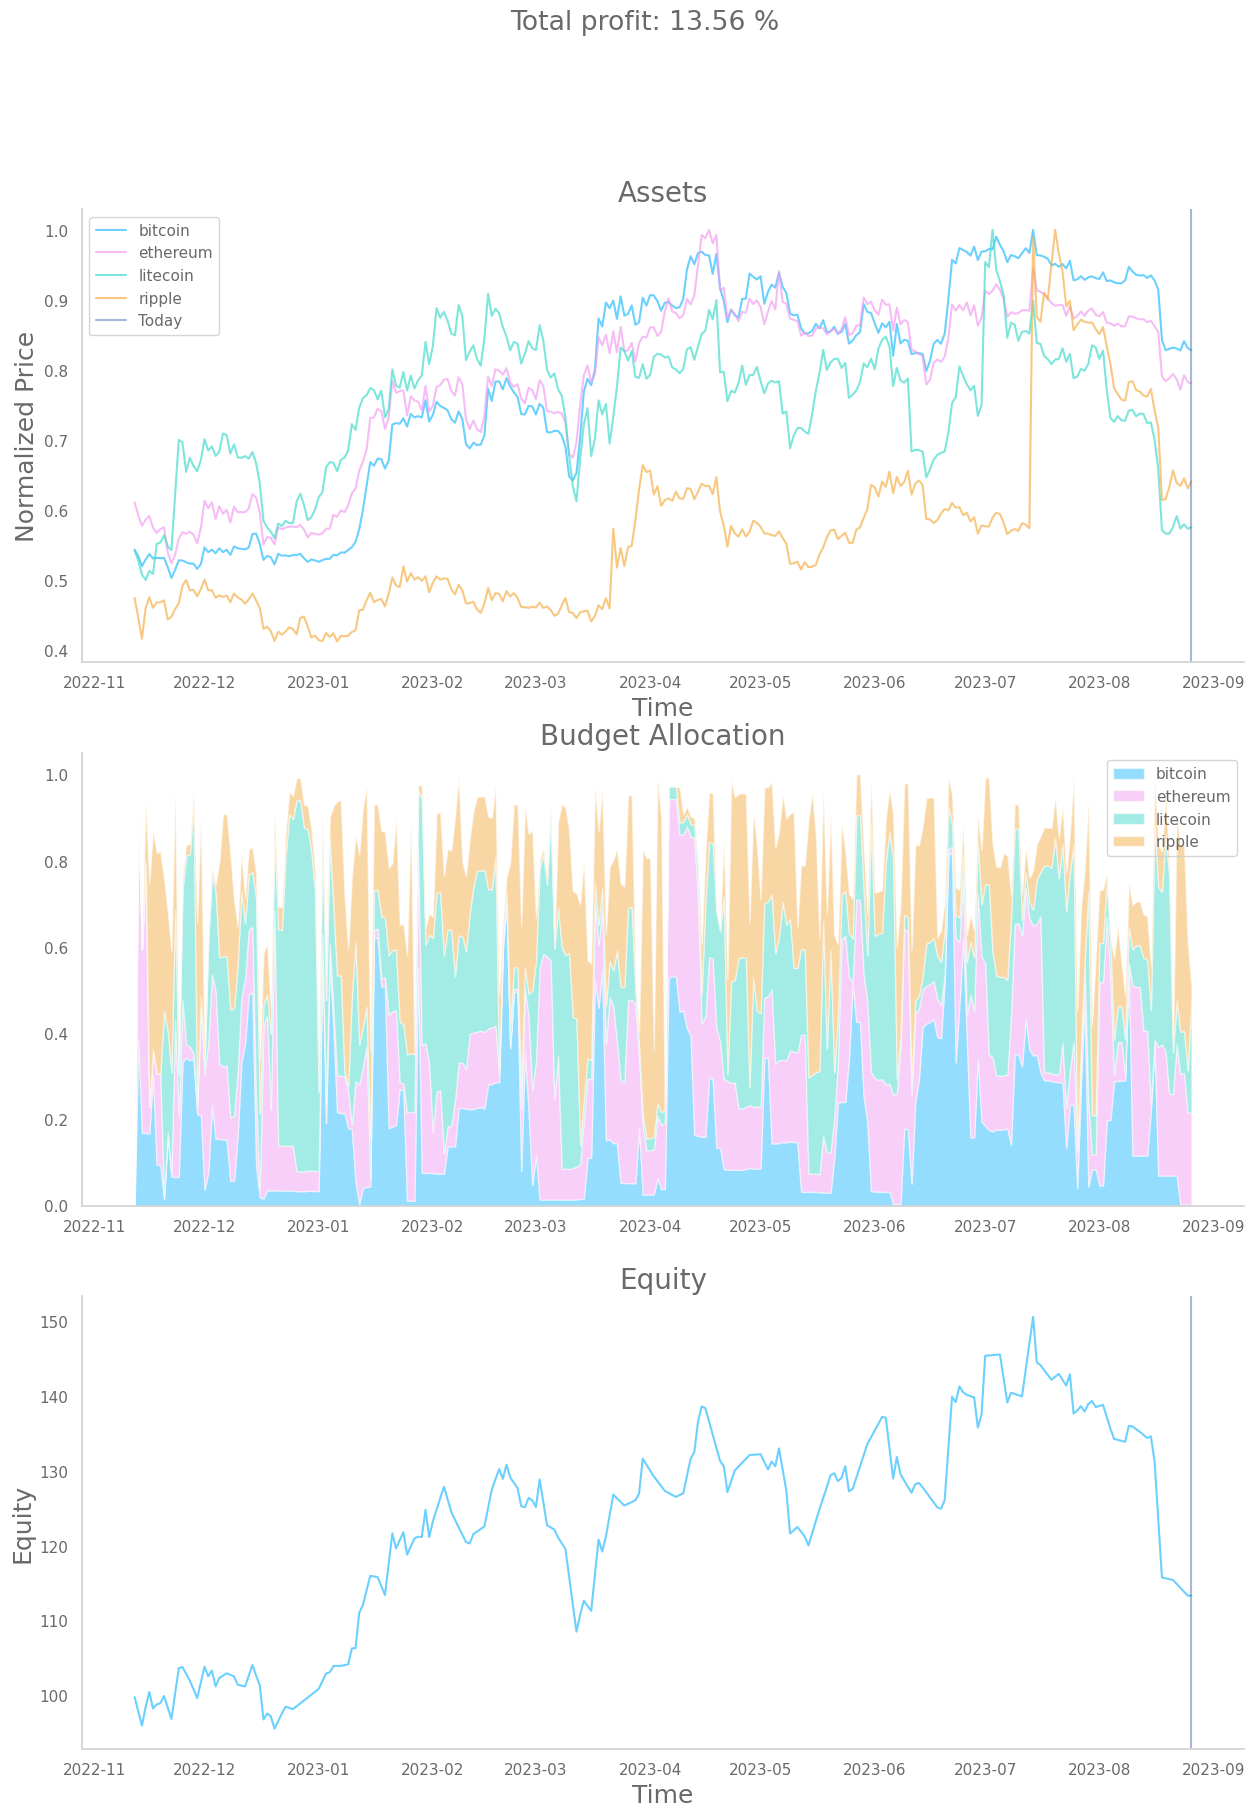

13.563357762736361

In [13]:
simulate(RandomAgent(), test_env, render=True)

Simulating a trading session with agent: UniformAgent


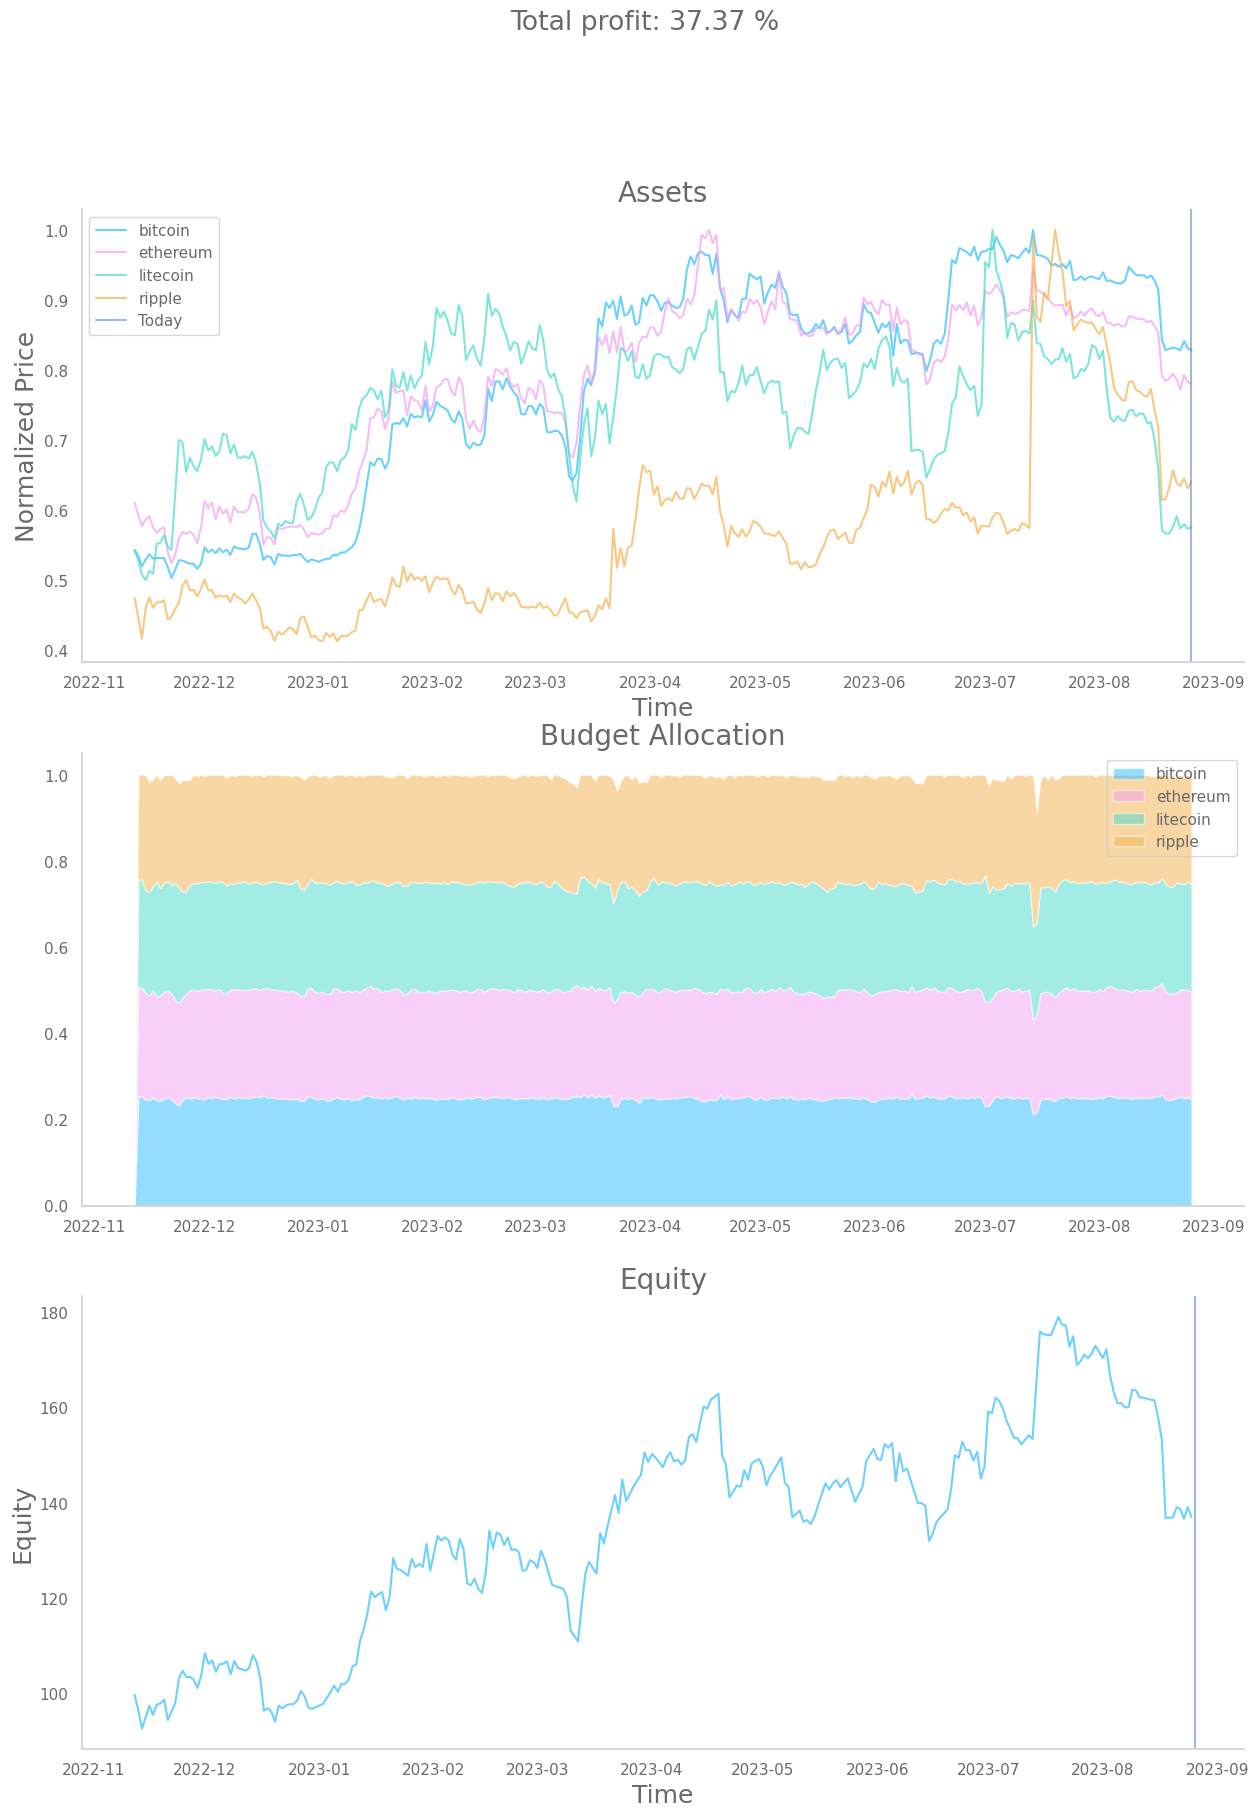

37.37016848063344

In [14]:
simulate(UniformAgent(), test_env, render=True)

In [15]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def preprocess(observation):
    scaled_data = StandardScaler().fit_transform(observation.reshape(-1, 1))
    return scaled_data.reshape(1, -1)

In [16]:
preprocess(observation)

array([[-0.42086676,  3.2841177 , -0.06728344, -0.42086697,  0.00598202,
        -0.25182733, -0.42086697, -0.32864836, -0.36565647, -0.42086697,
        -0.19559428, -0.39762223]], dtype=float32)

In [17]:
from typing import List, Any, Tuple, SupportsFloat
from gymnasium.experimental.functional import ObsType
from gymnasium.core import ActType

class GymWrapper(gym.Env):
    
    def __init__(self, env):
        super(GymWrapper, self).__init__()
        
        self.env = env
        self.action_space = env.action_space
        self.observation_space = env.observation_space

    def reset(
        self,
        *,
        seed: int | None = None,
        options: dict[str, Any] | None = None,
    ) -> tuple[ObsType, dict[str, Any]]:
        observation, info = self.env.reset()
        return preprocess(observation), info

    def step(
        self, action: ActType
    ) -> tuple[ObsType, SupportsFloat, bool, bool, dict[str, Any]]:
        observation, reward, done, truncated, info = self.env.step(action)
        observation = preprocess(observation)
        return observation, reward, done, truncated, info

In [18]:
class SB3Agent(Agent):
    
    def __init__(self, model):
        self.model = model

    def action(self, observation: np.ndarray) -> np.ndarray:
        action = self.model.predict(preprocess(observation), deterministic=True)[0]
        # print(action, action.shape)
        return action

In [19]:
from stable_baselines3.common.vec_env import SubprocVecEnv, VecNormalize, StackedObservations

# Creating and wrapping the environments
train_vec_env = SubprocVecEnv([lambda: GymWrapper(train_env)] * 8)
valid_vec_env = DummyVecEnv([lambda: GymWrapper(valid_env)])
test_vec_env = DummyVecEnv([lambda: GymWrapper(test_env)])

In [20]:
# def evaluate(model, vec_env):
# #     mean_reward, std_reward = evaluate_policy(
# #         model, 
# #         vec_env, 
# #         n_eval_episodes=1,
# #         deterministic=True,
# #         render=False
# #     )
#     for env in vec_env.envs:
#         simulate(model, env, render=True)
#         env.render()
# #     print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

In [21]:
log_dir = './logs/'
time_steps = 500_000

model = PPO(
    policy="MlpPolicy",
    env=train_vec_env,
    verbose=1,
    tensorboard_log=log_dir,
)

Using cuda device


Evaluate on test env before training
Simulating a trading session with agent: SB3Agent


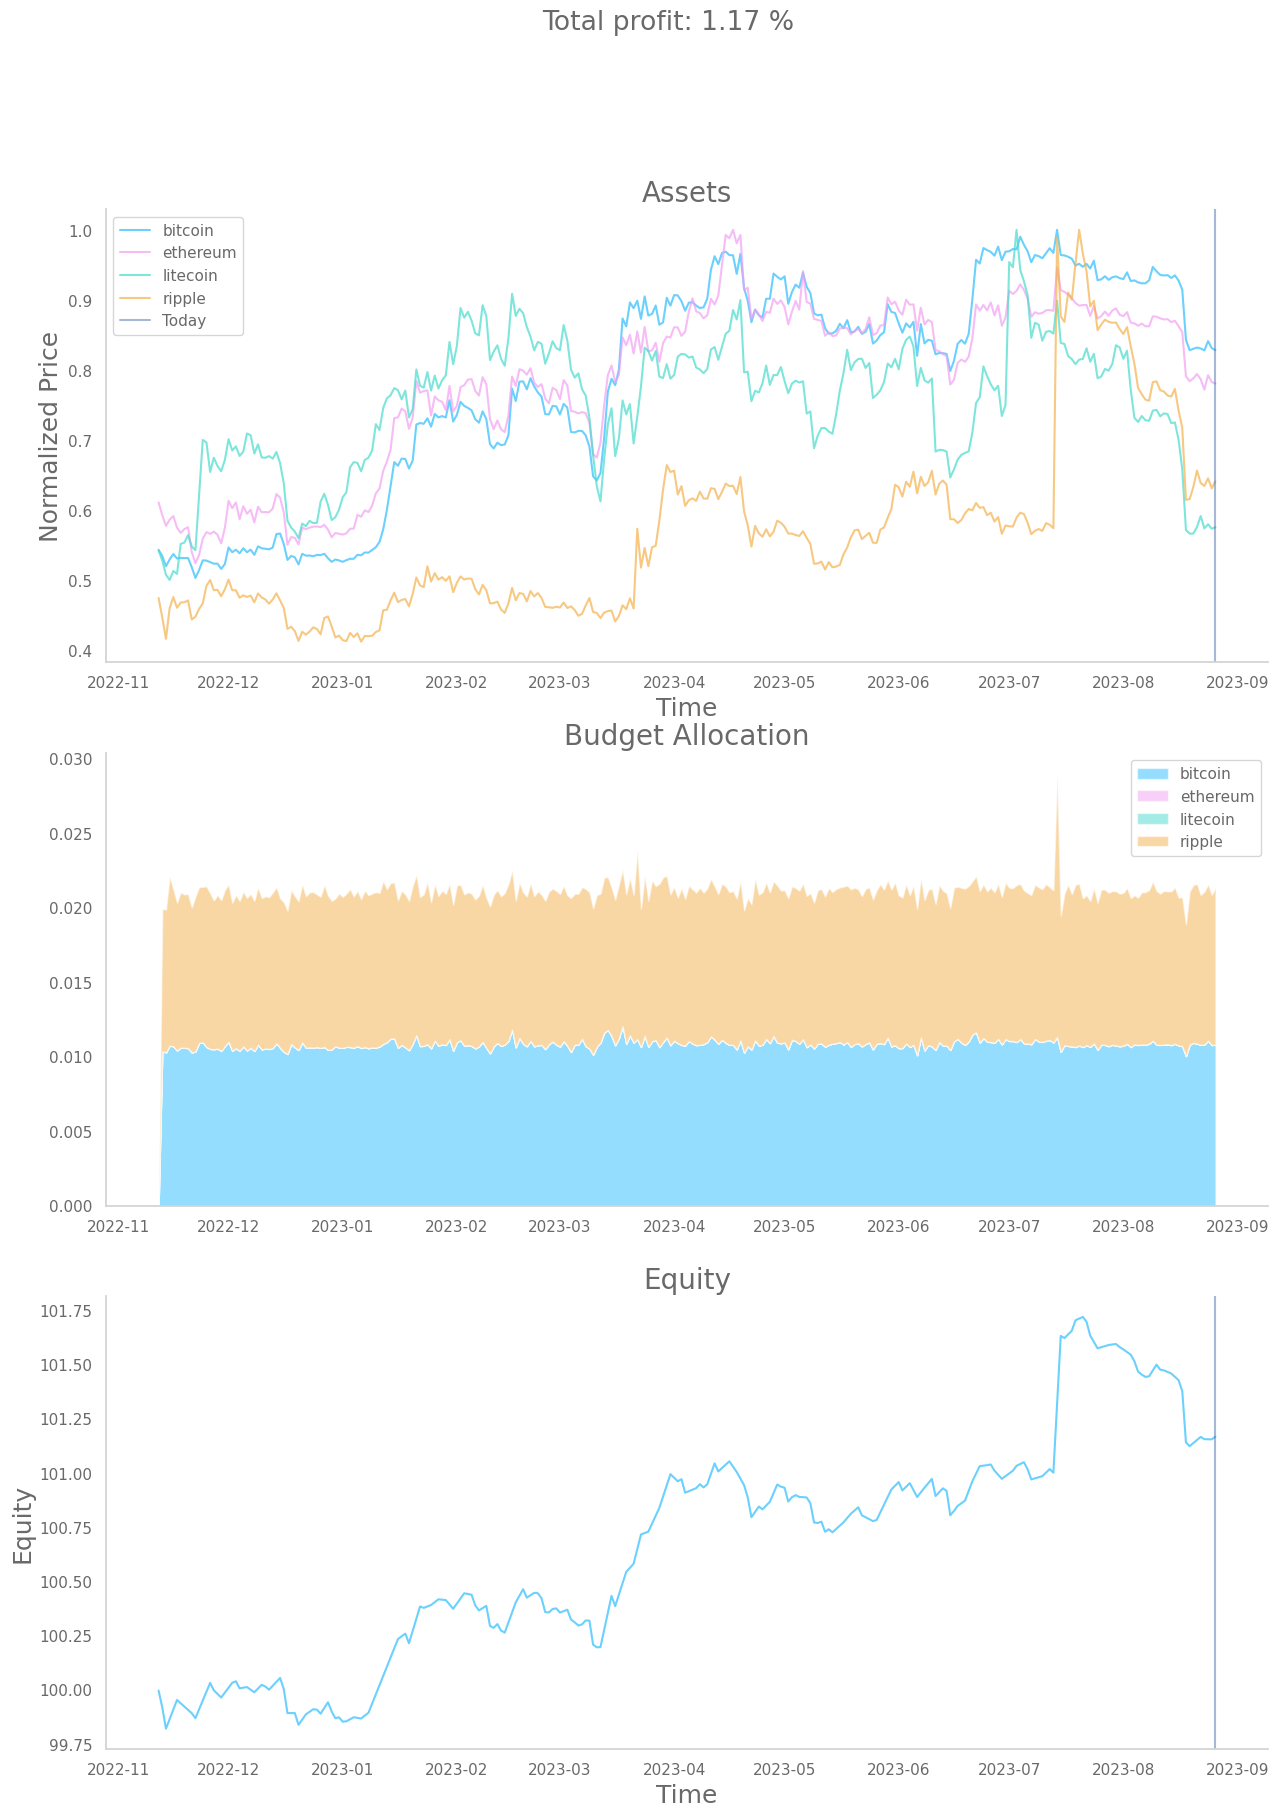

1.1715086154575394

In [22]:
print('Evaluate on test env before training')
simulate(SB3Agent(model), test_env, render=True)

In [ ]:
eval_callback = EvalCallback(
    eval_env=valid_vec_env,
    best_model_save_path='./models',
    log_path=log_dir,
    eval_freq=1000,
    n_eval_episodes=1,
    deterministic=True,
    render=False
)

callbacks = [eval_callback]

model.learn(
    total_timesteps=time_steps,
    callback=callbacks,
    progress_bar=True
)

Logging to ./logs/PPO_9


Output()

Eval num_timesteps=8000, episode_reward=-260.54 +/- 0.00

Episode length: 231.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 231      |
|    mean_reward     | -261     |
| time/              |          |
|    total_timesteps | 8000     |
---------------------------------


New best mean reward!

Eval num_timesteps=16000, episode_reward=-260.54 +/- 0.00

Episode length: 231.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 231      |
|    mean_reward     | -261     |
| time/              |          |
|    total_timesteps | 16000    |
---------------------------------
------------------------------
| time/              |       |
|    fps             | 360   |
|    iterations      | 1     |
|    time_elapsed    | 45    |
|    total_timesteps | 16384 |
------------------------------


Eval num_timesteps=24000, episode_reward=-141.22 +/- 0.00

Episode length: 231.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 231         |
|    mean_reward          | -141        |
| time/                   |             |
|    total_timesteps      | 24000       |
| train/                  |             |
|    approx_kl            | 0.003327364 |
|    clip_fraction        | 0.00947     |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.68       |
|    explained_variance   | 6.27e-05    |
|    learning_rate        | 0.0003      |
|    loss                 | 5.86e+06    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.000443   |
|    std                  | 1           |
|    value_loss           | 1.19e+07    |
-----------------------------------------


New best mean reward!

Eval num_timesteps=32000, episode_reward=-141.22 +/- 0.00

Episode length: 231.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 231      |
|    mean_reward     | -141     |
| time/              |          |
|    total_timesteps | 32000    |
---------------------------------
------------------------------
| time/              |       |
|    fps             | 333   |
|    iterations      | 2     |
|    time_elapsed    | 98    |
|    total_timesteps | 32768 |
------------------------------


Eval num_timesteps=40000, episode_reward=-189.01 +/- 0.00

Episode length: 231.00 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 231          |
|    mean_reward          | -189         |
| time/                   |              |
|    total_timesteps      | 40000        |
| train/                  |              |
|    approx_kl            | 0.0033256242 |
|    clip_fraction        | 0.0145       |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.67        |
|    explained_variance   | 2.15e-06     |
|    learning_rate        | 0.0003       |
|    loss                 | 3.82e+06     |
|    n_updates            | 20           |
|    policy_gradient_loss | -0.000895    |
|    std                  | 0.998        |
|    value_loss           | 7.34e+06     |
------------------------------------------


Eval num_timesteps=48000, episode_reward=-189.01 +/- 0.00

Episode length: 231.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 231      |
|    mean_reward     | -189     |
| time/              |          |
|    total_timesteps | 48000    |
---------------------------------
------------------------------
| time/              |       |
|    fps             | 324   |
|    iterations      | 3     |
|    time_elapsed    | 151   |
|    total_timesteps | 49152 |
------------------------------


Eval num_timesteps=56000, episode_reward=-677.74 +/- 0.00

Episode length: 231.00 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 231          |
|    mean_reward          | -678         |
| time/                   |              |
|    total_timesteps      | 56000        |
| train/                  |              |
|    approx_kl            | 0.0028193644 |
|    clip_fraction        | 0.0139       |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.66        |
|    explained_variance   | 7.75e-07     |
|    learning_rate        | 0.0003       |
|    loss                 | 3.9e+06      |
|    n_updates            | 30           |
|    policy_gradient_loss | -0.00111     |
|    std                  | 0.994        |
|    value_loss           | 7.38e+06     |
------------------------------------------


Eval num_timesteps=64000, episode_reward=-677.74 +/- 0.00

Episode length: 231.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 231      |
|    mean_reward     | -678     |
| time/              |          |
|    total_timesteps | 64000    |
---------------------------------
------------------------------
| time/              |       |
|    fps             | 319   |
|    iterations      | 4     |
|    time_elapsed    | 205   |
|    total_timesteps | 65536 |
------------------------------


Eval num_timesteps=72000, episode_reward=-547.86 +/- 0.00

Episode length: 231.00 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 231          |
|    mean_reward          | -548         |
| time/                   |              |
|    total_timesteps      | 72000        |
| train/                  |              |
|    approx_kl            | 0.0041461997 |
|    clip_fraction        | 0.0139       |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.65        |
|    explained_variance   | 0.0551       |
|    learning_rate        | 0.0003       |
|    loss                 | 3.74e+06     |
|    n_updates            | 40           |
|    policy_gradient_loss | -0.000946    |
|    std                  | 0.992        |
|    value_loss           | 5.7e+06      |
------------------------------------------


Eval num_timesteps=80000, episode_reward=-547.86 +/- 0.00

Episode length: 231.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 231      |
|    mean_reward     | -548     |
| time/              |          |
|    total_timesteps | 80000    |
---------------------------------
------------------------------
| time/              |       |
|    fps             | 316   |
|    iterations      | 5     |
|    time_elapsed    | 258   |
|    total_timesteps | 81920 |
------------------------------


Eval num_timesteps=88000, episode_reward=-583.42 +/- 0.00

Episode length: 231.00 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 231          |
|    mean_reward          | -583         |
| time/                   |              |
|    total_timesteps      | 88000        |
| train/                  |              |
|    approx_kl            | 0.0037557613 |
|    clip_fraction        | 0.0231       |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.64        |
|    explained_variance   | 0.0813       |
|    learning_rate        | 0.0003       |
|    loss                 | 3.23e+06     |
|    n_updates            | 50           |
|    policy_gradient_loss | -0.00129     |
|    std                  | 0.99         |
|    value_loss           | 5.29e+06     |
------------------------------------------


Eval num_timesteps=96000, episode_reward=-583.42 +/- 0.00

Episode length: 231.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 231      |
|    mean_reward     | -583     |
| time/              |          |
|    total_timesteps | 96000    |
---------------------------------


In [ ]:
%load_ext tensorboard
%tensorboard --logdir ./logs/

In [ ]:
best_model = PPO.load('./models/best_model.zip')

simulate(SB3Agent(best_model), test_env, render=True)

In [ ]:
# best_model = PPO.load('./models/best_model.zip')

# evaluate(best_model, test_vec_env)
# test_vec_env.envs[0].render()